# Learning pytorch geometric 
- https://www.youtube.com/watch?v=JtDgmmQ60x8
- Tutorial 1

In [3]:
import torch
import torch_geometric
from torch_geometric.datasets import Planetoid
torch_geometric.__version__

'2.0.1'

In [56]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

### Setting the device

In [122]:
device = torch.device('cuda' if torch.cuda.is_available()  else 'cpu')
device  = torch.device('cpu')
device

device(type='cpu')

## Load the dataset

In [23]:
dataset = Planetoid(root="../pytorch_dataset/", name="Cora")
# - https://graphsandnetworks.com/the-cora-dataset/

### about dataset

In [12]:
print(dataset)
print(f"No of graphs {len(dataset)}")
print(f"No of edge features {dataset.num_edge_features}")
print(f"No of node features {dataset.num_node_features}")

Cora()
No of graphs 1
No of edge features 0
No of node features 1433


### Data attribute

In [14]:
dataset.data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [22]:
dataset.url

'https://github.com/kimiyoung/planetoid/raw/master/data'

#### edges

In [16]:
dataset.data.edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

In [18]:
dataset.data.edge_index.shape
# 10556 is the no of edges

torch.Size([2, 10556])

Notes
- the is tensor represents the edges between two nodes
- 0 in the first row and 633 in the second row, represents that 
    - there exists a edge from node 0 to node 633, 0 <---> 633

#### feature matrix

In [19]:
dataset.data.x.shape

torch.Size([2708, 1433])

In [20]:
dataset.data.x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

#### y_labels

In [109]:
dataset.data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

## Creating graph from the edge index

In [104]:
number_of_samples = 300
number_of_nodes = dataset.data.x.shape[0]
idx_random_sample_of_edge_index = torch.randint(high=number_of_nodes-1 , size=(number_of_samples,))

idx_random_sample_of_edge_index.shape

torch.Size([300])

In [105]:
random_edge_index = dataset.data.edge_index[:, :number_of_samples].T # taking inital N edges
# random_edge_index = dataset.data.edge_index[:, idx_random_sample_of_edge_index].T

random_edge_index = random_edge_index.numpy()
random_edge_index.shape

(300, 2)

In [106]:
G = nx.Graph()
G.add_edges_from(random_edge_index)

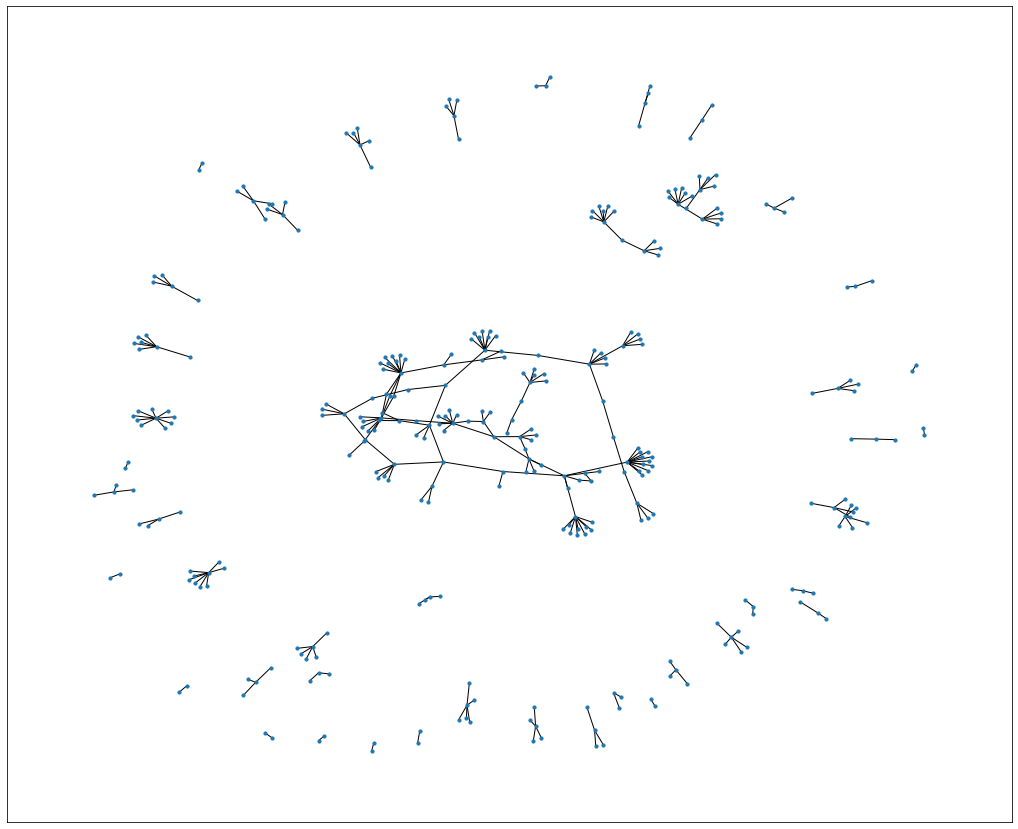

In [108]:
plt.figure(figsize=(18,15))
nx.draw_networkx(G, with_labels=False, node_size=10)
# plt.show()

In [123]:
data = dataset[0]

## A simple graph neural net

In [133]:
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch import nn
from loguru import logger

In [117]:
N_FEATURES = dataset.num_node_features
N_CLASSES = dataset.num_classes

In [119]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = SAGEConv(in_channels=N_FEATURES,
                             out_channels=N_CLASSES,
                             aggr="max"
                            )
    def forward(self, x, edge_index):
        x = self.conv(x, edge_index)
        return F.log_softmax(x, dim=1)

### How does SAGEConv Work?
- https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.SAGEConv

### Model instance

In [124]:
model = Net().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [128]:
def train():
    model.train()
    optimizer.zero_grad()
    h = model(data.x, data.edge_index)
    loss = F.nll_loss(h[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [129]:
def test():
    model.eval()
    logits =  model(data.x, data.edge_index)
    accs = []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

### Training

In [136]:
best_val_acc = test_acc = 0
for epoch in range(1,100):
    train()
    _, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    
    if epoch % 10 == 0:
        logger.info(f"Epoch: {epoch}, Val: {best_val_acc:.4f}, Test: {test_acc:.4f}")

2022-01-16 16:56:15.224 | INFO     | __main__:<module>:11 - Epoch: 10, Val: 0.7200, Test: 0.7260
2022-01-16 16:56:17.166 | INFO     | __main__:<module>:11 - Epoch: 20, Val: 0.7200, Test: 0.7260
2022-01-16 16:56:19.143 | INFO     | __main__:<module>:11 - Epoch: 30, Val: 0.7200, Test: 0.7260
2022-01-16 16:56:21.061 | INFO     | __main__:<module>:11 - Epoch: 40, Val: 0.7200, Test: 0.7260
2022-01-16 16:56:22.971 | INFO     | __main__:<module>:11 - Epoch: 50, Val: 0.7200, Test: 0.7260
2022-01-16 16:56:24.884 | INFO     | __main__:<module>:11 - Epoch: 60, Val: 0.7200, Test: 0.7260
2022-01-16 16:56:26.818 | INFO     | __main__:<module>:11 - Epoch: 70, Val: 0.7220, Test: 0.7300
2022-01-16 16:56:28.728 | INFO     | __main__:<module>:11 - Epoch: 80, Val: 0.7220, Test: 0.7300
2022-01-16 16:56:30.631 | INFO     | __main__:<module>:11 - Epoch: 90, Val: 0.7220, Test: 0.7300
